# ML in Cybersecurity: Task II

## Team
  * **Team name**:  team0x
  * **Members**:  Yu Xiao (s8xiyuuu@stud.uni-saarland.de)


## Logistics
  * **Due date**: 25th Nov. 2021, 23:59:59 (email the completed notebook including outputs to mlcysec_ws2022_staff@lists.cispa.saarland)
  * Email the completed notebook to mlcysec_ws2022_staff@lists.cispa.saarland 
  * Complete this in the previously established **teams of 3**
  * Feel free to use the course forum to discuss.
  
  
## About this Project
In this project, we dive into the vulnerabilities of machine learning models and the difficulties of defending against them. To this end, we ask you to implement an evasion attack (craft adversarial examples) yourselves, and defend your own model.   


## A Note on Grading
The total number of points in this project is 100. We further provide the number of points achievable with each excercise. You should take particular care to document and visualize your results.

Whenever possible, please use tools like tables or figures to compare the different findings


 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with (all) your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
  ---

In [ ]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [2]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [11]:
compute_mode = 'gpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

#### Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [267]:

# ------- Your Code -------
def fgsm(img, grad, epsl):
    sign_grad = grad.sign()
    perturbed_img = img + epsl*sign_grad
    perturbed_img.requires_grad_()
    # into range [0,1]
    perturbed_img = torch.clamp(perturbed_img, 0, 1)
    return perturbed_img


def plot_adv_sample(adv_sample):
    images_ori = [None for _ in range(10)]
    adv_fgsm = [None for _ in range(10)]
    adv_pred = [None for _ in range(10)]
    visited = [1 for _ in range(10)]

    for ori_img, preturbed_img, label, preturbed_pred in adv_sample:
        if sum(visited) == 0: 
            break
        if visited[label] == 0: 
            continue
        images_ori[label] = ori_img
        adv_fgsm[label] = preturbed_img
        adv_pred[label] = preturbed_pred
        visited[label] = 0

    # template code (Please feel free to change this)
    # (each column corresponds to one attack method)
    col_titles = ['ori','ifgsm-0.1'] 
    nsamples = 10
    nrows = nsamples
    ncols = len(col_titles)

    fig, axes = plt.subplots(nrows,ncols,figsize=(8,12))  # create the figure with subplots
    [ax.set_axis_off() for ax in axes.ravel()]  # remove the axis


    for i in range(nsamples):
        axes[i, 0].imshow(images_ori[i])
        axes[i, 0].set_title(f'ori_pred:{i}',
                                fontdict={'fontsize':14, 'color':'b'})
        axes[i, 1].imshow(adv_fgsm[i])
        axes[i, 1].set_title(f'adv_pred:{adv_pred[i]}',
                                fontdict={'fontsize':14, 'color':'b'})

    fig.tight_layout()  

# 1. Attacking an ML-model (30 points) 

In this section, we implement an attack ourselves. First, however, you need a model you can attack. Feel free to choose the DNN/ConvNN from task 1.



## 1.1: Setting up the model and data (4 Points)

Load the MNIST data, as done in task 1. 

Re-use the model from task 1 here and train it until it achieves reasonable accuracy (>92%).

If you have the saved checkpoint from task 1, you can load it directly. But please compute here the test accuracy using this checkpoint.  

**Hint:** In order to save computation time for the rest of exercise, you might consider having a relatively small model here.

**Hint**: You might want to save the trained model to save time later.

In [14]:
#
#
# ------- Your Code -------
# Feel free to change this part depending on whether you would train a model or directly load a checkpoint 
#
#

# (1)load data 
BATCH_SIZE = 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, ), (.5, ))  
])
# load training and test set
mnist_trainset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

train_loader = DataLoader(mnist_trainset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=True)


In [5]:
# (2)define model
# CNN from task01
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(14*14*128, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 10)
        )
    def forward(self, inputs):
        x = self.conv(inputs)
        x = x.view(-1, 14*14*128)
        x = self.classifier(x)
        return x

In [9]:
def test(model, device, test_loader):
    
    with torch.no_grad():
        tp = 0
        y_pred = torch.randn(1, 1)
        model.eval()
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            _, pred = torch.max(output, 1)
            # get correct_pred
            tp += torch.sum(pred == y).item()
            y_pred = torch.cat((y_pred, pred.unsqueeze(0).cpu()), 1)
        
        acc = tp / len(test_loader) / BATCH_SIZE   
        print('accurary on test dataset: {}'.format(acc))
        
        return y_pred[0, 1:]

In [15]:
# (3)define loss, optimizer 
# (4)train (You can re-use the trained model from project1)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pretrained_model = './run/best.pth'
model = Net().to(device)
model.load_state_dict(torch.load(pretrained_model, map_location=device))
model.eval()

# (5)evaluate
pred = test(model, device)
# print('Epoch %d, Train acc: %f, Test acc: %f' % (epoch, train_acc, test_acc))

accurary on test dataset: 0.987


## 1.2: Implementing the FGSM attack (7 Points)

We now want to attack the model trained in the previous step. We will start with the FGSM attack as a simple example. 

Please implement the FGSM attack mentioned in the lecture. 

More details: https://arxiv.org/pdf/1412.6572.pdf


In [31]:

# ------- Your Code -------
def test_attack(model, device, epsl):
    cor = 0
    adv_sample = []
    for image, label in test_loader:
        image, label = image.to(device), label.to(device)
        image.requires_grad = True
        
        output = model(image)
        pred = torch.max(output, 1)[1]
        
        if pred.item() != label.item():
            continue
        loss = F.nll_loss(output, label)
        
        model.zero_grad()
        loss.backward()
        
        grad = image.grad.data
        # get perturbed image
        perturbed_img = fgsm(image, grad, epsl)
        output = model(perturbed_img)
        
        perturbed_pred = torch.max(output, 1)[1]
        
        if perturbed_pred.item() == label.item():
            cor += 1
        else:
            img = image.squeeze().detach().cpu().numpy()
            adv_img = perturbed_img.squeeze().detach().cpu().numpy()
            adv_sample.append((img, adv_img, pred, perturbed_pred))
    acc = cor / len(test_loader)
    print(f'epsilon: {epsl}, acc: {acc}')
    return adv_sample

## 1.3: Adversarial sample set (7 Points)

* Please generate a dataset containing at least 1,000 adversarial examples using FGSM.

* Please vary the perturbation budget (3 variants) and generate 1,000 adversarial examples for each. 
    * **Hint**: you can choose epsilons within, e.g., = [.05, .1, .15, .2, .25, .3],  using MNIST pixel values in the interval       [0, 1]

* Compute the accuracy of each attack set. 

In [35]:

# ------- Your Code -------
adv_samples = []
epsilons = [0.1, 0.2, 0.3]
for epsl in epsilons:
    start = time.time()
    adv_sample = test_attack(model, device, epsl)
    end = time.time()
    print(f'runtime: {end-start:.4f}s, size of sample: {len(adv_sample)}')
    adv_samples.append(adv_sample)


epsilon: 0.1, acc: 0.8545
runtime: 28.7575s, size of sample: 1325
epsilon: 0.2, acc: 0.7085
runtime: 28.8030s, size of sample: 2785
epsilon: 0.3, acc: 0.5259
runtime: 28.7446s, size of sample: 4611


## 1.4: Visualizing the results (7 Points)

* Please chose one sample for each class (for example the first when iterating the test data) and plot the (ten) adversarial examples as well as the predicted label (before and after the attack)

* Please repeat the visualization for the three sets you have created 

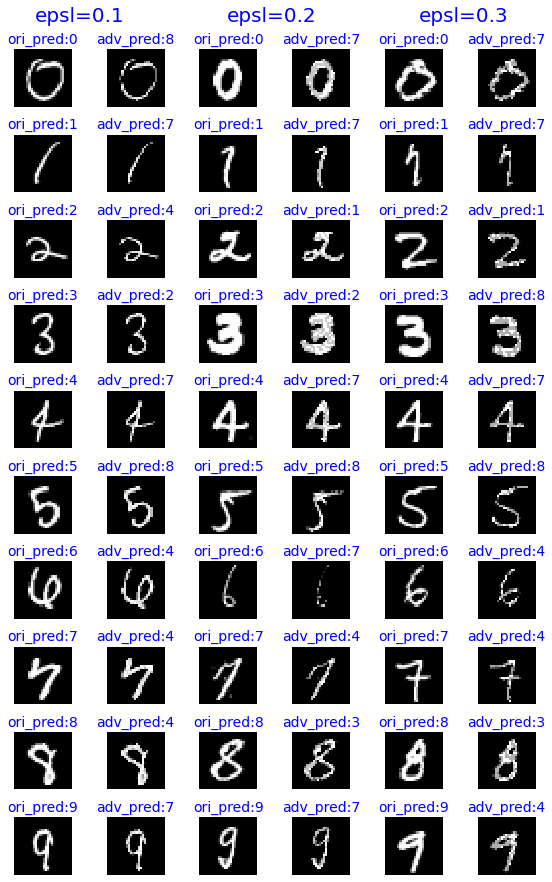

In [62]:

# ------- Your Code -------

images_ori = [[None for _ in range(10)] for _ in range(3)]
adv_fgsm = [[None for _ in range(10)] for _ in range(3)]
adv_pred = [[None for _ in range(10)] for _ in range(3)]
for i, adv_sample in enumerate(adv_samples):
    visited = [1 for _ in range(10)]
    for ori_img, preturbed_img, pred, preturbed_pred in adv_sample:
        if sum(visited) == 0: 
            break
        if visited[pred] == 0: 
            continue
        images_ori[i][pred] = ori_img
        adv_fgsm[i][pred] = preturbed_img
        adv_pred[i][pred] = preturbed_pred.item()
        visited[pred] = 0

# template code (Please feel free to change this)
# (each column corresponds to one attack method)
col_titles = ['ori','fgsm-0.1', 'ori', 'fgsm-0.2', 'ori', 'fgsm-0.3'] 
nsamples = 10
nrows = nsamples
ncols = len(col_titles)

fig, axes = plt.subplots(nrows,ncols,figsize=(8,12))  # create the figure with subplots
[ax.set_axis_off() for ax in axes.ravel()]  # remove the axis


for i in range(nsamples):
    for j in range(ncols // 2):
        axes[i, 2*j].imshow(images_ori[j][i])
        axes[i, 2*j].set_title(f'ori_pred:{i}',
                                fontdict={'fontsize':14, 'color':'b'})
        axes[i, 2*j+1].imshow(adv_fgsm[j][i])
        axes[i, 2*j+1].set_title(f'adv_pred:{adv_pred[j][i]}',
                                fontdict={'fontsize':14, 'color':'b'})
for i, epsl in enumerate(epsilons):
    plt.figtext((0.5+i*2)/6, 1, f'epsl={epsl}',
               fontdict={'fontsize':20, 'color':'b'})

fig.tight_layout()                  

## 1.5: Analyzing the results (5 Points)

Please write a brief summary of your findings.  

* Does the attack always succeed (the model makes wrong prediction on the adversarial sample)? What is the relationship between the attack success rate and the perturbation budget?
* How about the computation cost of the attack? (you can report the time in second) 
* Does the attack require white-box access to the model?
* Feel free to report your results via tables or figures, and mention any other interesting observations 



**Answers**
- Not always, since the accuracy on adversarial sample is above 0. The larger the pertubation budget becomes, the higher the attack sucess rate could get.
- The model was run on GPU with batch size 1 and for each epsilon it costs about 28s.
- Yes. The attack needs the gradient after backpropagation.



# 2. Defending an ML model (35 points) 

So far, we have focused on attacking an ML model. In this section, we want you to defend your model. 


## 2.1: Implementing the adversarial training defense (20 Points)

* We would like to ask you to implement the adversarial training defense (https://arxiv.org/pdf/1412.6572.pdf) mentioned in the lecture. 

* You can use the **FGSM adversarial training** method (i.e., train on FGSM examples). 

* You can also check the adversarial training implementation in other papers, e.g., http://proceedings.mlr.press/v97/pang19a/pang19a.pdf 

* Choose a certain **maximum perturbation budget** during training that is in the middle of the range you have experimented with before. 

* We do not require the defense to work perfectly - but what we want you to understand is why it works or why it does not work.

**Hint:** You can save the checkpoint of the defended model as we would need it to for the third part of this exercise.


In [68]:

# ------- Your Code -------
# teacher model f  (original model) (x, y) --> softmax with temp T=100 : exp(o/T) / sum(oi/T)
# student model f' (distlled model) (x, f(x)) with T=100
class DistilledNet(nn.Module):
    def __init__(self):
        super(DistilledNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(14*14*64, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, 10)
        )
    def forward(self, inputs):
        x = self.conv(inputs)
        x = x.view(-1, 14*14*64)
        x = self.classifier(x)
        return x


In [83]:
# data preparation
def get_preturbed_set(model, dataloader, epsl):
    x, y = [], []
    for image, label in dataloader:
        label = torch.tensor(label)
        image, label = image.to(device), label.to(device)
        image.requires_grad = True

        output = model(image)
        pred = torch.max(output, dim=1)[1]
        loss = F.nll_loss(output, label)
        model.zero_grad()
        loss.backward()

        grad = image.grad.data
        perturbed_img = fgsm(image, grad, epsl)
        x.append(perturbed_img.detach().cpu())
        y.append(label.detach().cpu())
    return x, y

def get_loader(x, y, batch_size):
    x, y = torch.stack(x), torch.stack(y)
    dataset = TensorDataset(x, y)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    return dataloader

In [ ]:
batch_size = 64

# train and eval set - choose middle epsilon
x_trainval, y_trainval = get_preturbed_set(model, train_loader, 0.2)
train_size = int(0.7 * len(x_trainval))
x_train, y_train = x_trainval[:train_size], y_trainval[:train_size]
x_val, y_val = x_trainval[train_size:], y_trainval[train_size:]

x_train = [x.squeeze(0) for x in x_train]
x_val = [x.squeeze(0) for x in x_val]
train_loader_dist = get_loader(x_train, y_train, batch_size)
val_loader_dist = get_loader(x_val, y_val, batch_size)

# test set list with diffferent epsilons
test_loader_list = []

for epsl in epsilons:
    x_test, y_test = get_preturbed_set(model, test_loader, epsl)
    x_test = [x.squeeze(0) for x in x_test]
    dataloader = get_loader(x_test, y_test, batch_size)
    test_loader_list.append(dataloader)


In [220]:
train_loader_ori = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)
test_loader_ori = DataLoader(mnist_testset, batch_size=batch_size, shuffle=True)

In [146]:
print(len(train_loader_dist))
print(len(val_loader_dist))
print(len(test_loader_list[0]))

657
282
157


In [255]:
def train(adv_model, train_loader, val_loader, device, 
          loss_f, optimizer, epochs):
    best_cor = 0
    best_epoch = 0
    best_model_dir = './run/best_adv.pth'
    for epoch in tqdm(range(epochs)):
        adv_model.train()
        optimizer.zero_grad()
        
        cor = 0
        start = time.time()
        for inputs, labels in train_loader:
            labels = labels.squeeze()
            inputs, labels = inputs.to(device), labels.to(device)
            inputs.requires_grad_()
            
            outputs = adv_model(inputs)
            
            c, epsl = 0.4, 0.2 # torch.randint(500, (1, )).item() * 1e-3
            loss = c * loss_f(outputs, labels)
            loss.backward(retain_graph=True)
            
            grad = inputs.grad.data
            perturbed = fgsm(inputs, grad, epsl)
            prb_outputs = adv_model(perturbed)
            loss += (1-c) * loss_f(prb_outputs, labels)

            loss.backward()
            optimizer.step()
        
        with torch.no_grad():
            adv_model.eval()
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = adv_model(inputs)
                preds = torch.max(outputs, dim=1)[1]
                cor += torch.sum(preds == labels.squeeze()).item()
            if cor > best_cor:
                model_dir = os.path.dirname(best_model_dir)
                if not os.path.exists(model_dir):
                    os.makedirs(model_dir)
                torch.save(adv_model.state_dict(), best_model_dir)
                best_cor = cor
                best_epoch = epoch
        end = time.time()
        acc = cor / len(val_loader) / batch_size
        best_acc = best_cor / len(val_loader) / batch_size
        print(f'epoch: {epoch}, runtime: {end-start:.4f}s')
        print(f'loss on train set: {loss.item():.4f}')
        print(f'acc on eval set: {acc:.4f}')
        print(f'best epoch: {best_epoch} with acc: {best_acc:.4f}')
    

In [ ]:
# training
# model.load_state_dict(torch.load(pretrained_model, map_location=device))
adv_model = Net().to(device)
loss_f = nn.CrossEntropyLoss(reduce='sum').to(device)
optimizer = optim.Adam(adv_model.parameters(), lr=1e-4)

In [256]:
train(adv_model, train_loader_ori, test_loader_ori, device, loss_f, optimizer, 10)

 10%|█         | 1/10 [00:26<03:54, 26.10s/it]

epoch: 0, runtime: 26.0967s
loss on train set: 0.0573
acc on eval set: 0.9827
best epoch: 0 with acc: 0.9827


 20%|██        | 2/10 [00:51<03:26, 25.85s/it]

epoch: 1, runtime: 25.6780s
loss on train set: 0.0707
acc on eval set: 0.9811
best epoch: 0 with acc: 0.9827


 30%|███       | 3/10 [01:17<03:01, 25.87s/it]

epoch: 2, runtime: 25.9000s
loss on train set: 0.0055
acc on eval set: 0.9821
best epoch: 0 with acc: 0.9827


 40%|████      | 4/10 [01:57<03:07, 31.30s/it]

epoch: 3, runtime: 39.6070s
loss on train set: 0.0588
acc on eval set: 0.9833
best epoch: 3 with acc: 0.9833


 50%|█████     | 5/10 [02:22<02:26, 29.23s/it]

epoch: 4, runtime: 25.5513s
loss on train set: 0.0053
acc on eval set: 0.9825
best epoch: 3 with acc: 0.9833


 60%|██████    | 6/10 [02:48<01:51, 27.98s/it]

epoch: 5, runtime: 25.5698s
loss on train set: 0.0055
acc on eval set: 0.9830
best epoch: 3 with acc: 0.9833


 70%|███████   | 7/10 [03:14<01:21, 27.20s/it]

epoch: 6, runtime: 25.5926s
loss on train set: 0.0640
acc on eval set: 0.9795
best epoch: 3 with acc: 0.9833


 80%|████████  | 8/10 [03:39<00:53, 26.70s/it]

epoch: 7, runtime: 25.6363s
loss on train set: 0.0787
acc on eval set: 0.9829
best epoch: 3 with acc: 0.9833


 90%|█████████ | 9/10 [04:05<00:26, 26.58s/it]

epoch: 8, runtime: 26.3115s
loss on train set: 0.0022
acc on eval set: 0.9842
best epoch: 8 with acc: 0.9842


100%|██████████| 10/10 [04:31<00:00, 27.15s/it]

epoch: 9, runtime: 25.5785s
loss on train set: 0.1655
acc on eval set: 0.9839
best epoch: 8 with acc: 0.9842


## 2.2: Evaluation (10 Points)

* Craft adversarial examples using the **defended** model. This entails at least 1,000 examples crafted via FGSM. 
    * Create one set using a budget that is **less than (within)** the one used in training.
    * Create another set using a budget that is **higher than** the one used in training. 
    * You can use two values of epsilons from question 1.3 
    
* Evaluate the **defended** model on these two adversarial examples sets. 


In [215]:
def test_dist(model, test_loader, device, batch_size):
    with torch.no_grad():
        cor = 0
        model.eval()
        for images, labels in tqdm(test_loader):
            labels = labels.squeeze()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.max(outputs, dim=1)[1]
            cor += torch.sum(preds == labels).item()
        acc = cor / len(test_loader) / batch_size
    return acc

In [257]:

# ------- Your Code -------
model.load_state_dict(torch.load(pretrained_model, map_location=device))
acc_FGSM1 = test_dist(model, test_loader_list[0], device, batch_size)
acc_FGSM_defend1 = test_dist(distilled_model, test_loader_list[0], device, batch_size)
acc_FGSM2 = test_dist(model, test_loader_list[2], device, batch_size)
acc_FGSM_defend2 = test_dist(distilled_model, test_loader_list[2], device, batch_size)

print('Accuracy on the lower-budget adversarial samples (FGSM) %.2f'%acc_FGSM1)
print('Accuracy on the lower-budget adversarial samples (FGSM) after defense %.2f'%acc_FGSM_defend1)
print('Accuracy on the higher-budget adversarial samples (FGSM) %.2f'%acc_FGSM2)
print('Accuracy on the higher-budget adversarial samples (FGSM) after defense %.2f'%acc_FGSM_defend2)

100%|██████████| 157/157 [00:00<00:00, 634.43it/s]

Accuracy on the lower-budget adversarial samples (FGSM) 0.85
Accuracy on the lower-budget adversarial samples (FGSM) after defense 0.97
Accuracy on the higher-budget adversarial samples (FGSM) 0.52
Accuracy on the higher-budget adversarial samples (FGSM) after defense 0.94


## 2.3 Discussion (5 points)

* How successful was the defense against the attack compared to the undefended model? How do you interpret the difference?
* How did the two sets differ?

**Answer**
- With different epsilons the accuracy on adversarial samples after defense maintains 0.9 while it drops drastically with the previous undefended model. The distilled model learns both from relation bewteen output logits and class as well as the relation bewteen different classes.
- One set is generated with lower epsilon than the trainset, the other one is higher.

# 3: I-FGSM attack (35 points) 

* FGSM is one of the simplest and earliest attacks. Since then, many more advanced attacks have been proposed. 
* One of them is the Iterative-FGSM (https://arxiv.org/pdf/1607.02533.pdf), where the attack is repeated multiple times.
* In this part, we ask you to please implement the iterative FGSM attack. 



## 3.1: Implementing the I-FGSM attack (10 Points)

**Hints**: 

* Your code should have an attack loop. At each step, the FGSM attack that you have implemented before is computed using a small step.
* After each step, you should perform a per-pixel clipping to make sure the image is in the allowed range, and that the perturbation is within budget.


In [260]:
fgsm??

Signature: fgsm(img, grad, epsl)
Docstring: <no docstring>
Source:   
def fgsm(img, grad, epsl):
    sign_grad = grad.sign()
    perturbed_img = img + epsl*sign_grad
    perturbed_img.requires_grad_()
    # into range [0,1]
    perturbed_img = torch.clamp(perturbed_img, 0, 1)
    return perturbed_img
File:      /media/cfs/xiaoyu13/twin-bert/mlsec/<ipython-input-201-eb7afca8cc89>
Type:      function


In [263]:

# ------- Your Code -------
def try_ifgsm(model, device, test_loader, steps=1, epsl=0.1, get_sample=False):
    cor = 0
    adv_sample = []
    
    start = time.time()
    for image, label in tqdm(test_loader):
        label = torch.tensor(label)
        image, label = image.to(device), label.to(device)
        image.requires_grad_()
        output = model(image)
        pred = torch.max(output, dim=1)[1]
        if pred.item() != label.item():
            continue
        loss = F.nll_loss(output, label)
        model.zero_grad()
        loss.backward()
        
        grad = image.grad.data
        perturbed_img = fgsm(image, grad, epsl)
        
        for _ in range(1, steps):
#             print(perturbed_img.requires_grad)
            perturbed_img.retain_grad()
            output = model(perturbed_img)
            pred = torch.max(output, dim=1)[1]
            if pred.item() != label.item():
                break
            loss = F.nll_loss(output, label)
            model.zero_grad()
            loss.backward(retain_graph=True)
            
            grad = perturbed_img.grad.data
            perturbed_img = fgsm(perturbed_img, grad, epsl)
            
        if pred.item() == label.item():
            cor += 1
        elif get_sample:
            img = image.squeeze().detach().cpu().numpy()
            adv_img = perturbed_img.squeeze().detach().cpu().numpy()
            adv_sample.append((img, adv_img, label.item(), pred.item()))
            
    end = time.time()
    acc = cor / len(test_loader) / BATCH_SIZE
    print(f'steps: {steps}, epsl: {epsl}, acc: {acc}, runtime: {end-start:.4f}s')
    return adv_sample

## 3.2: Attack the undefended model (5 Points)

* We will first attack the **undefended model** (i.e., without adversarial training).

* Choose one perturbation budget from Question **1.3** for comparison. 

    * Hint: A simple way to choose the small step is to divide the total budget by the number of steps (e.g., 10).

* Please generate 1000 adversarial examples using the **undefended** model and the **I-FGSM** you implemented. 

* Please compute the accuracy of the adversarial set on the **undefended** model. 

In [200]:

# ------- Your Code -------
model.load_state_dict(torch.load(pretrained_model, map_location=device))
model.eval()
for steps in range(1, 10):
    epsl = 0.1
    try_ifgsm(model, device, test_loader, steps, epsl)
    

  0%|          | 23/10000 [00:00<00:44, 225.92it/s]

steps: 1, epsl: 0.1, acc: 0.987, runtime: 25.9533s


  0%|          | 19/10000 [00:00<00:52, 188.76it/s]

steps: 2, epsl: 0.1, acc: 0.8545, runtime: 42.4167s


  0%|          | 20/10000 [00:00<00:51, 194.09it/s]

steps: 3, epsl: 0.1, acc: 0.3315, runtime: 50.9129s


  0%|          | 16/10000 [00:00<01:03, 158.20it/s]

steps: 4, epsl: 0.1, acc: 0.0719, runtime: 54.1123s


  0%|          | 22/10000 [00:00<00:45, 218.50it/s]

steps: 5, epsl: 0.1, acc: 0.0133, runtime: 54.9947s


  0%|          | 18/10000 [00:00<00:56, 177.12it/s]

steps: 6, epsl: 0.1, acc: 0.0015, runtime: 55.2459s


  0%|          | 20/10000 [00:00<00:53, 185.35it/s]

steps: 7, epsl: 0.1, acc: 0.0001, runtime: 55.4557s


  0%|          | 16/10000 [00:00<01:02, 159.80it/s]

steps: 8, epsl: 0.1, acc: 0.0, runtime: 55.9807s


100%|██████████| 10000/10000 [00:56<00:00, 178.15it/s]

steps: 9, epsl: 0.1, acc: 0.0, runtime: 56.1335s


In [264]:
adv_sample_ifgsm = try_ifgsm(model, device, test_loader, 10, 0.1, True)

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
100%|██████████| 10000/10000 [00:55<00:00, 180.11it/s]

steps: 10, epsl: 0.1, acc: 0.0, runtime: 55.5233s


### plot adversarial samples

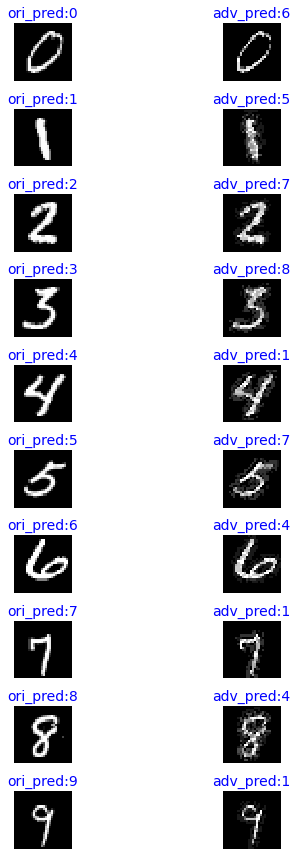

In [268]:
plot_adv_sample(adv_sample_ifgsm)    

### 3.2.1: Findings and comparison with FGSM (8 points)

* Please report your findings. How successful was the attack? 

* What do you expect when increasing the number of steps? (you can experiment with different parameters of the attack and report your findings) 

* Compare with the basic FGSM. Using the same perturbation budget and using the same model, which attack is more successful? Why do you think this is the case? What about the computation time?

* Feel free to report any interesting observations. 

**Answers**
- It is successful.
- With increasing of the steps, the accuracy becomes lower.


## 3.3: Attack the defended model (5 poinst) 

* In the previous question, we attacked the **undefended model**. 

* Now, we want to explore how successful the previous implemented defense (FGSM adversarial training) is againts this new attack. (we will not implement a new defense here, we will be reusing your previous checkpoint of the **defended model**)


* Use the **defended model** to create one set of adversarial examples. Use a perturbation budget from Question **2.2** for comparison.  

In [258]:
acc_on_ori_aft_dfs = test_dist(distilled_model, test_loader, device, BATCH_SIZE)
print(acc_on_ori_aft_dfs)

100%|██████████| 10000/10000 [00:09<00:00, 1092.04it/s]

0.9871


In [259]:

# ------- Your Code -------
distilled_model_dir = './run/best_dist.pth'
distilled_model.load_state_dict(torch.load(distilled_model_dir, map_location=device))
distilled_model.eval()

for steps in range(1, 10):
    epsl = 0.1
    try_ifgsm(distilled_model, device, test_loader, steps, epsl)

  0%|          | 28/10000 [00:00<00:35, 277.84it/s]

steps: 1, epsl: 0.1, acc: 0.9871, runtime: 20.0090s


  0%|          | 19/10000 [00:00<00:53, 187.15it/s]

steps: 2, epsl: 0.1, acc: 0.9634, runtime: 35.8217s


  0%|          | 18/10000 [00:00<00:56, 176.93it/s]

steps: 3, epsl: 0.1, acc: 0.8532, runtime: 50.6108s


  0%|          | 15/10000 [00:00<01:08, 145.68it/s]

steps: 4, epsl: 0.1, acc: 0.5129, runtime: 61.5587s


  0%|          | 15/10000 [00:00<01:07, 148.94it/s]

steps: 5, epsl: 0.1, acc: 0.065, runtime: 65.1694s


  0%|          | 17/10000 [00:00<01:02, 160.97it/s]

steps: 6, epsl: 0.1, acc: 0.002, runtime: 63.8449s


  0%|          | 15/10000 [00:00<01:08, 145.74it/s]

steps: 7, epsl: 0.1, acc: 0.0005, runtime: 63.7082s


  0%|          | 16/10000 [00:00<01:02, 159.07it/s]

steps: 8, epsl: 0.1, acc: 0.0003, runtime: 63.8295s


100%|██████████| 10000/10000 [01:05<00:00, 152.12it/s]

steps: 9, epsl: 0.1, acc: 0.0003, runtime: 65.7374s


In [261]:
adv_sample_ifgsm_dfs = try_ifgsm(adv_model, device, test_loader, 10, 0.1, True)

100%|██████████| 10000/10000 [00:56<00:00, 175.46it/s]

steps: 10, epsl: 0.1, acc: 0.0, runtime: 56.9958s


### plot adversarial samples

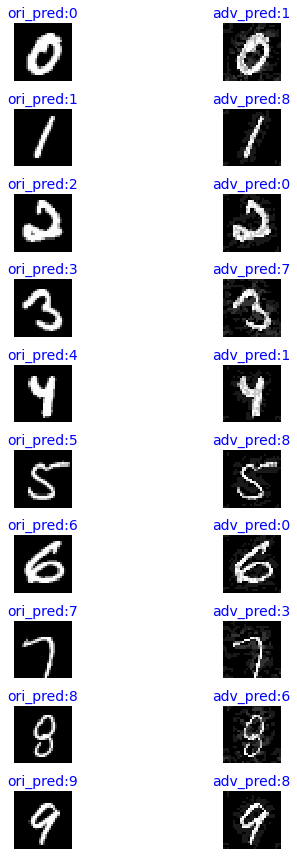

In [269]:
plot_adv_sample(adv_sample_ifgsm_dfs)

### 3.3.1: Discussion (7 points) 
* Please report your results. How successful was the attack on the defended model? 
* Compare it with the success of the FGSM attack on the defended model. What do you observe? How do you interpret the difference? 
* How do you think you can improve the defense against I-FGSM attack?


* Feel free to state any interesting findings you encountered during this project.

**Answers**
- with epsilon 0.1, after step 5, the accuracy becomes quite low.
- with iteration the perturbations keep doing gradient ascent, while defended model only learns local perturbation.
- try similar iterative approach, with step 10 or above, calculate loss at each step.